# Analysis

League of Legends is a competitive video game owned by Riot Games in which 10 players compete against each other in teams of 5. It is one of the most played and viewed video games in the world. Since 2011, Riot Games has hosted professional "leagues" in various regions around the world. The best teams from each region come to the Wold Championship where the best team wins the Summoner's Cup. Since its inception, the World Championship has been dominated by the Asian regions. If we look at the top 5 teams from the World Championships since 2014, we can see that Chinese and Korean teams usually dominate the field:

In [154]:
import sqlite3, os
import pandas as pd
from parsing_utils import parse_databases
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
match,random = parser.get_dbs(db_dir)

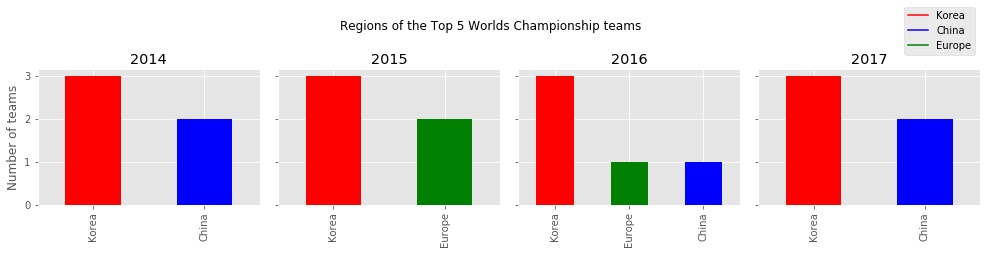

In [195]:
regions = {'2014':['Korea','Korea','Korea','China','China'],'2015':['Korea','Korea','Europe','Europe','Korea'],
          '2016':['Korea','Korea','Korea','Europe','China'],'2017':['Korea','Korea','China','China','Korea']}
fig,ax = plt.subplots(1,4,figsize=(14,3), sharey=True)
axes = ax.flatten()
colors = {'Korea':'r','China':'b','Europe':'g'}
n=0
axes[0].set_ylabel("Number of teams")
for ii in ['2014','2015','2016','2017']:
    query="""SELECT name FROM international.'sqlite_master' WHERE type = 'table' 
    AND name LIKE '%championships%' AND name LIKE '%team%' AND name LIKE '%{}%';""".format(ii)
    table = pd.read_sql_query(query,match).iloc[0,0]
    query="""SELECT * FROM international.'{}' ORDER BY W DESC, L ASC;""".format(table)
    top5 = pd.read_sql_query(query,match).head(5)
    top5["Region"] = regions[ii]
    cols = [colors[ii] for ii in top5["Region"].value_counts().index.values]
    top5["Region"].value_counts().plot.bar(ax = axes[n], color = [cols])
    axes[n].set_title("{}".format(ii))
    n+=1
plt.suptitle("Regions of the Top 5 Worlds Championship teams",y=1.1)
legend = [plt.Line2D([0],[0],color='r',label='Korea'),plt.Line2D([0],[0],color='b',label='China')
          ,plt.Line2D([0],[0],color='g',label='Europe')]
plt.legend(handles=legend, loc='upper right',bbox_to_anchor=(1, 1.5))
plt.tight_layout()
plt.show()

European teams have made it into the top 5 in 2015 and 2016 but Korean teams have been 3 out of the top 5 teams consistently. Since 2013, Korean teams have also won the World Championship. There has been much speculation about the Korean dominance in the professional League of Legends circuit. In particular, many people have wondered why North America never seems to make it into the top 5 despite having the largest recruiting pool and the most enthusiastic fan base. I will try to answer the question by analyzing matches from the LCK (Korean circuit) and NA(North American circuit). Specifically, I will be comparing LCK with NA matches. I unfortunately only have complete match data for the 2016 and 2017 seasons so I will be limited to the last couple of years but lets see what we can find! 
## Choosing teams
In order to make a fair comparison between the two regions, I have to pick teams that I believe best represent these regions. I decided to use teams that made it to the Spring or Summer season playoffs in the respective years. If a team made it to either of the playoffs that year, that means they must have been better than at least half the teams in their region in that season since only half the teams that compete in a region move to the playoffs. Thus, I will be comparing the top 50% of Korean teams with the top 50% of North American teams in that same year. First let's get the 2017 matches for playoff teams in LCK and NA. I have custom scripts that parse my databases and give me the matches I want. The specific implementation can be found in `parsing_utils.py`. 
## Match team statistics

First, lets look at the overall team stats for each match. This will give us team wide stats for each match rather than each player's stats:

In [178]:
def get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins):
    all_matches = {}
    parser = parse_databases()
    for ii, jj in zip(aliases,leagues):
        alias = ii
        league = jj
        name = "{}_{}_{}_{}s".format(year,alias,season,focus)
        matches  = parser.parse_tables_get_matches(db_dir,alias,joins,anti_joins,name,year,league)
        try:
            all_matches[matches["league"].value_counts().index.values[0]] = matches
            print(matches["league"].value_counts())
        except:
            print("League {} does not have any data for {}".format(jj,season))
    return all_matches

def get_fig_axes(n=1,m=2,w=10,h=5,sharey=False):
    fig,ax = plt.subplots(n,m,figsize=(w,h),sharey=sharey)
    axes = ax.flatten()
    return fig,axes

db_dir =  ".//databases"
year = "2017"
focus = "team"
season = "playoffs"
joins = [year,focus,season]
anti_joins = ["na-cs","eu-cs"]
aliases = ["na","lck"]
leagues = ["NALCS","LCK"]
parser = parse_databases()
all_matches = get_matches(db_dir, year, focus, season, aliases, leagues, joins, anti_joins)
na = all_matches["NALCS"]
lck = all_matches["LCK"]

NALCS    782
Name: league, dtype: int64
LCK    606
Name: league, dtype: int64


The teams that made it to any of the NA playoffs in 2017 played a total of 782 matches together whereas the LCK teams played 606 matches. The reason for this discrepancy becomes clear when we look at the number of teams:

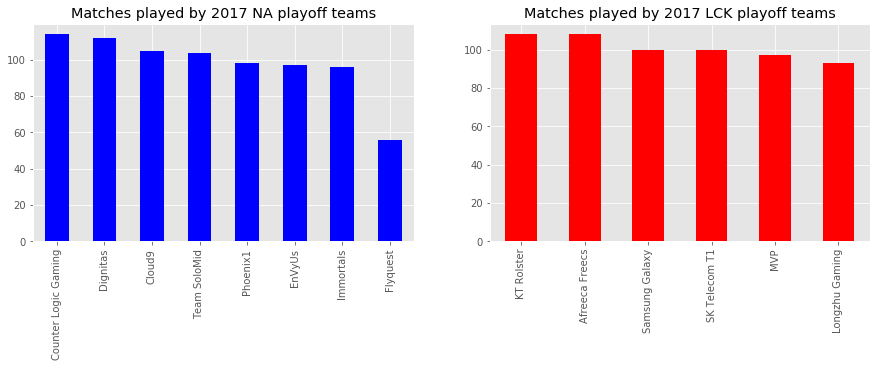

In [179]:
fig,axes = get_fig_axes(1,2,15,4)
na["team"].value_counts().plot.bar(ax=axes[0],color='b')
axes[0].set_title("Matches played by 2017 NA playoff teams")
lck["team"].value_counts().plot.bar(ax=axes[1],color='r')
axes[1].set_title("Matches played by 2017 LCK playoff teams")
plt.show()

There were only 6 teams from the LCK that made it to either the Spring or Summer playoffs compared with the 8 teams from NA. This seems to suggest that the matches in NA are more competitive than the matches in LCK. We can examine this more closely by looking at the ["GSPD"](https://oracleselixir.com/tag/gspd/) (Gold Spent Percentage Difference) statistic. "GSPD" measures if a match was a close one or if one team dominated. It measures the difference how much gold the winning team spent verses the losing team. If the difference is large, then it means the winning team had a large lead. If it is small or negative, then the losing team was keeping up in gold with the winning team. Lets compare the "GSPD" for NA vs LCK:

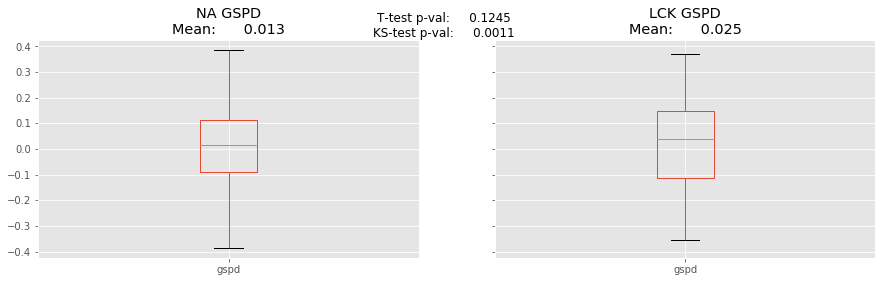

In [194]:
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
T_stat,p_val = ttest_ind(na["gspd"].values,lck["gspd"].values)
K_stat,p_val_k = ks_2samp(na["gspd"].values,lck["gspd"].values)
fig,axes = get_fig_axes(1,2,15,4,sharey=True)
na.boxplot('gspd',ax=axes[0])
axes[0].set_title("NA GSPD\nMean: {:10.3f}".format(na["gspd"].mean()))
lck.boxplot('gspd',ax=axes[1])
axes[1].set_title("LCK GSPD\nMean: {:10.3f}".format(lck["gspd"].mean()))
plt.suptitle("T-test p-val: {:10.4f}\nKS-test p-val: {:10.4f}".format(p_val,p_val_k))
plt.show()

Looking at the means and distributions, LCK in general had a higher GSPD than NA. I performed a KS test to measure if the two distributions were significantly different and a T-test for equality of the means. Although the T-test p-value is too high to say the two means are different, we can confidently say that the two distributions are different.

In [3]:
display(matches.loc[:,["team","league","split","side","gdat10",
                                   "gdat15","xpdat10","csdat10","fb","fbtime",
                                   "fbassist","ft","fttime","firstmidouter","result"]].head())

,team,league,split,side,gdat10,gdat15,xpdat10,csdat10,fb,fbtime,fbassist,ft,fttime,firstmidouter,result


To do:

1. How what are the variables that contribute to winning in each league  
    a. Look at early game and late/whole game features
    b. Look at contributions from different roles
2. What are the mean features that distinguish each region from another?  
    a. Look at teams as a whole vs individual players/roles
3. Cluster roles/regions?

Data Engineering:

Give me top x and bottom x teams from league from year from season

In [32]:
worlds_teams["league"].value_counts()

LCK       2025
NALCS     1535
LPL       1465
LMS       1460
EULCS     1270
WC         670
MSI        410
RRNAEU     210
RRAsia     190
NAPR        65
Name: league, dtype: int64

In [76]:
query = """SELECT * FROM data_dictionary.'player_team_stats_dictionary';"""
df = pd.read_sql_query(query,match)
display(df.head(10))

,index,Variable,Description
0,0,GP,Games Played
1,1,W,Wins
2,2,L,Losses
3,3,AGT,Average Game Time (sometimes also called “G Len”)
4,4,P%,Percentage of games champion was picked in the...
5,5,B%,Percentage of games in which the champion was ...
6,6,K,Total Kills
7,7,D,Total Deaths
8,8,A,Total Assists
9,9,KDA,Total Kill/Death/Assist Ratio


In [232]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if isinstance(df,pd.Series):
            df = df.to_frame()
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [233]:
s1 = na.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
s1 = s1.rename_axis("NA teams",axis=0).rename("2017 avg gspd")
s2 = lck.groupby("team").mean().sort_values("result",ascending=False)["gspd"]
s2 = s2.rename_axis("LCK teams",axis=0).rename("2017 avg gspd")
display_side_by_side(s1,s2)

,2017 avg gspd
NA teams,
Team SoloMid,0.043496
Cloud9,0.029514
Immortals,0.043137
Counter Logic Gaming,-0.011401
Dignitas,-0.008613
Flyquest,-0.013037
Phoenix1,-0.007144
EnVyUs,0.019668
,2017 avg gspd


In [230]:
print(s1)

NA teams
Team SoloMid            0.043496
Cloud9                  0.029514
Immortals               0.043137
Counter Logic Gaming   -0.011401
Dignitas               -0.008613
Flyquest               -0.013037
Phoenix1               -0.007144
EnVyUs                  0.019668
Name: gspd, dtype: float64
